In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#raw_data = pd.read_csv('/content/drive/MyDrive/Google Colab Notebooks/Mini Sem 8/dataset/large sample/reliance_2years_60min.csv')
raw_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/Final_csv/RELIANCE.csv')

In [4]:
time = []
for i in raw_data['Datetime']:
    date_list = i.split("+")
    time.append(date_list[0])

raw_data['Datetime']=time

In [5]:
# rename columns according to our older convention
raw_data.rename(
    {'Datetime':'time',
     'Open': 'open',
    'High': 'high',
    'Low' : 'low',
    'Close':'close',
    'Volume' : 'volume'},
    axis=1,
    inplace=True)

In [6]:
print(raw_data.shape)
raw_data.head()

(6404, 7)


,time,open,high,low,close,volume,Trading_code
0,2021-04-26 09:15:00,1920.00,1930.00,1912.00,1926.85,1061804,RELIANCE
1,2021-04-26 09:30:00,1927.00,1936.10,1925.05,1935.05,652372,RELIANCE
2,2021-04-26 09:45:00,1935.20,1949.75,1935.05,1949.25,707257,RELIANCE
3,2021-04-26 10:00:00,1949.15,1961.60,1949.10,1955.00,915519,RELIANCE
4,2021-04-26 10:15:00,1955.05,1958.20,1947.60,1950.95,609119,RELIANCE


In [7]:
open_ds = raw_data.loc[:, ['time', 'open']]
high_ds = raw_data.loc[:, ['time', 'high']]
low_ds = raw_data.loc[:, ['time', 'low']]
close_ds = raw_data.loc[:, ['time', 'close']]
volume_ds = raw_data.loc[:, ['time', 'volume']]

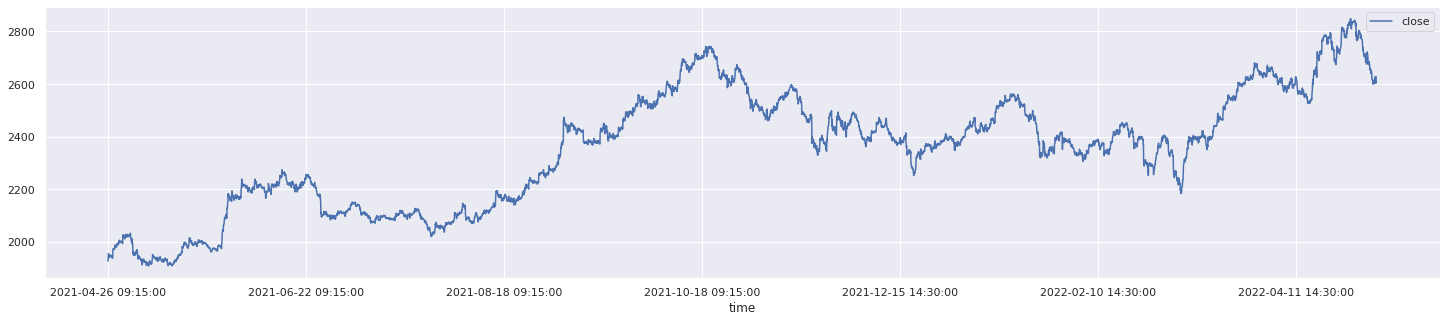

In [8]:
close_ds.plot(x='time', y='close', figsize=(25, 5))

In [9]:
# ema and vwap

from time import time
from datetime import datetime

"""
  Parameters
    d - previous number of data points to use for EMA
    price - stock price list
  Returns
    list of EMA of all points starting from the dth data point
"""
def calculate_ema(d, price) :
  print(f" Days {d} \n Length of prices {len(price)}")
  # formula https://www.investopedia.com/terms/e/ema.asp
  ema = []                                    # stores the ema starting from the dth data point i.e corresponding to price[d]
  ema_yesterday = sum(price[:d])/d            # sma of first d days, this will serve as the EMA of yesterday
  multiplier = 2/(d+1)                        # multiplier 
  for i in range(d,len(price)):
    ema_today = price[i]*multiplier + ema_yesterday*(1-multiplier)  
    ema.append(ema_today)
    ema_yesterday = ema_today
  print(f" Length of EMA list {len(ema)}")
  return ema



"""
  Parameters
    df - original dataframe
  Returns
    list of vwap
"""

def calculate_vwap(df):
  
  time_format = "%Y-%m-%d %H:%M:%S"
  
  sum_pv = 0
  sum_volume = 0
  
  vwap = []
  
  previous_day = datetime.strptime(df["time"][0], time_format).day

  for i in range(len(df)):
    
    current_day = datetime.strptime(df["time"][i], time_format).day

    if(current_day!=previous_day):
      sum_pv = 0
      sum_volume = 0

    previous_day = current_day

    sum_pv += ((df["high"][i] + df["low"][i] + df["close"][i])/3) * df["volume"][i]
    sum_volume += df["volume"][i]
    vwap.append(sum_pv/sum_volume)
  return vwap

In [10]:
# price list
price = list(close_ds.drop('time', axis=1).values)
print(f"len prices = {len(price)}")

# ema taking 10 previous points for calculation
ema = calculate_ema(10,price)
print(f"len ema = {len(ema)}")

vwap = calculate_vwap(raw_data)
print(f"len vwap = {len(vwap)}")

len prices = 6404
 Days 10 
 Length of prices 6404
 Length of EMA list 6394
len ema = 6394
len vwap = 6404


In [11]:
# make all ema, vwap, prices lists of equal length 
price = price[-len(ema):]
vwap = vwap[-len(ema):]

No handles with labels found to put in legend.


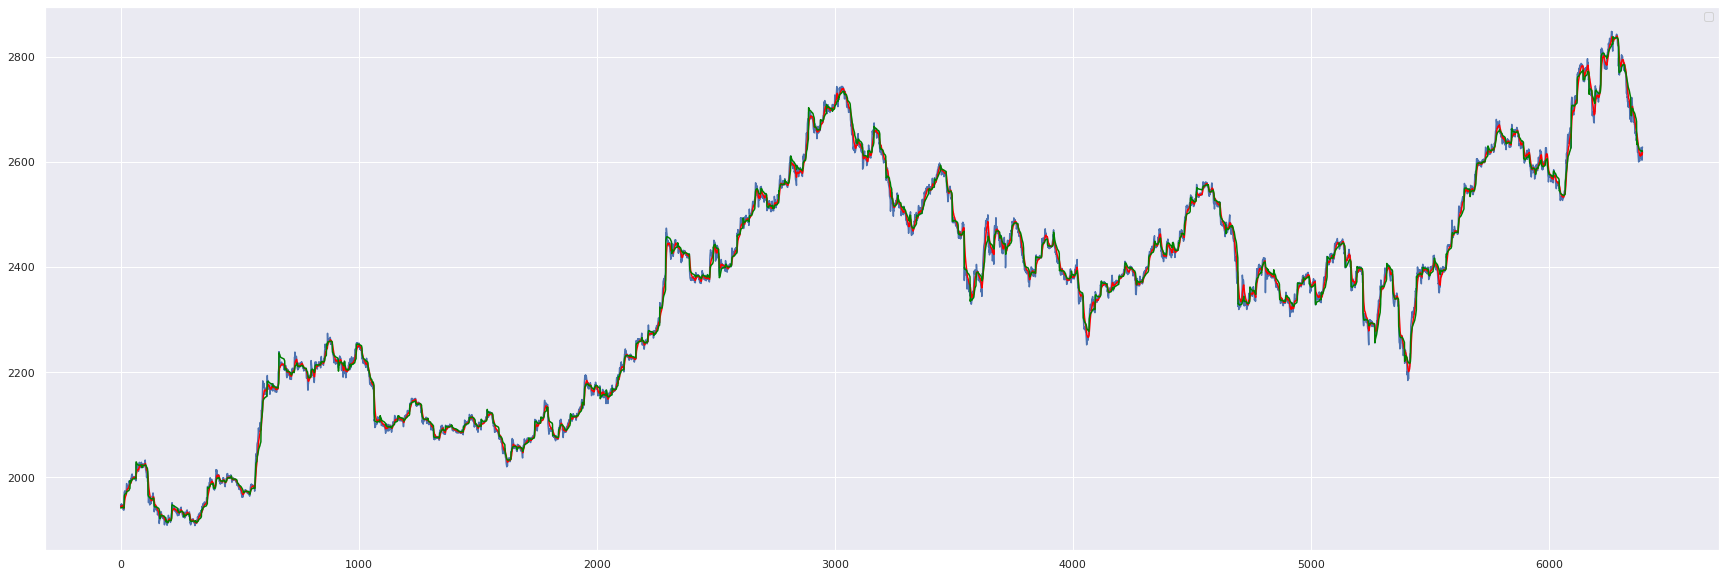

In [12]:
plt.figure(figsize=(30,10))

plt.plot(price)
plt.plot(ema, color='red')
plt.plot(vwap,color='green')
plt.legend()
plt.show()

In [13]:

# split a multivariate sequence into samples
# n_steps ---> number of lag observations

def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [14]:

ema = np.array(ema).reshape(len(ema), 1)
vwap = np.array(vwap).reshape(len(vwap), 1)
price = np.array(price).reshape(len(price), 1)
dataset = np.hstack((ema, vwap, price))
print(dataset)

[[1944.36681818 1941.6297111  1946.85      ]
 [1944.37285124 1941.71356597 1944.4       ]
 [1944.04142374 1941.75981017 1942.55      ]
 ...
 [2613.05616268 2620.0202848  2603.        ]
 [2615.34593347 2619.75506223 2625.649902  ]
 [2617.64667284 2620.33009701 2628.        ]]


In [15]:
n_steps = 3 
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
print(X[0], y[0])

(6392, 3, 3) (6392,)
[[1944.36681818 1941.6297111  1946.85      ]
 [1944.37285124 1941.71356597 1944.4       ]
 [1944.04142374 1941.75981017 1942.55      ]] 1942.55


In [16]:
# train_test_split 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
# type(X_train.values)

(4474, 3, 3)
(4474,)
(1918, 3, 3)
(1918,)


In [17]:
# flattening input for model feeding 

n_input = X_train.shape[1] * X_train.shape[2]
X_train_flattened = X_train.reshape((X_train.shape[0], n_input))
X_test_flattened = X_test.reshape((X_test.shape[0], n_input))
print(X_train_flattened.shape)
print(X_test_flattened.shape)

(4474, 9)
(1918, 9)


In [18]:
n_input = 9

In [19]:
# Model training

from tensorflow import keras 
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten

# Multilayer perceptron 

model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=n_input))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=0.0003))
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1000      
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


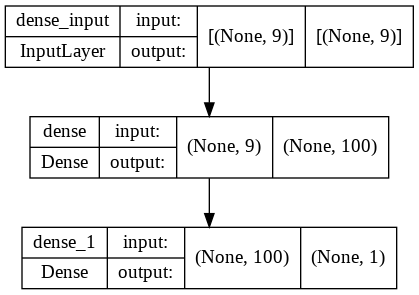

In [20]:
import tensorflow as tf
tf.keras.utils.plot_model(model_mlp, to_file="my_model.png", show_shapes=True)

In [21]:
mlp_history = model_mlp.fit(X_train_flattened, y_train, validation_data=(X_test_flattened, y_test), epochs=60, verbose=2)

Epoch 1/60
140/140 - 3s - loss: 152644.7344 - val_loss: 142.6734 - 3s/epoch - 25ms/step
Epoch 2/60
140/140 - 0s - loss: 86.7608 - val_loss: 142.4350 - 450ms/epoch - 3ms/step
Epoch 3/60
140/140 - 0s - loss: 86.7223 - val_loss: 142.8365 - 465ms/epoch - 3ms/step
Epoch 4/60
140/140 - 0s - loss: 86.6542 - val_loss: 142.2693 - 456ms/epoch - 3ms/step
Epoch 5/60
140/140 - 0s - loss: 86.6941 - val_loss: 142.2170 - 496ms/epoch - 4ms/step
Epoch 6/60
140/140 - 0s - loss: 86.7258 - val_loss: 142.4021 - 436ms/epoch - 3ms/step
Epoch 7/60
140/140 - 0s - loss: 87.0818 - val_loss: 142.1258 - 457ms/epoch - 3ms/step
Epoch 8/60
140/140 - 0s - loss: 86.7684 - val_loss: 142.4729 - 484ms/epoch - 3ms/step
Epoch 9/60
140/140 - 0s - loss: 87.3102 - val_loss: 141.8770 - 466ms/epoch - 3ms/step
Epoch 10/60
140/140 - 0s - loss: 86.5999 - val_loss: 142.1324 - 438ms/epoch - 3ms/step
Epoch 11/60
140/140 - 0s - loss: 87.4853 - val_loss: 141.6501 - 451ms/epoch - 3ms/step
Epoch 12/60
140/140 - 0s - loss: 86.3079 - val_los

Text(0, 0.5, 'MSE')

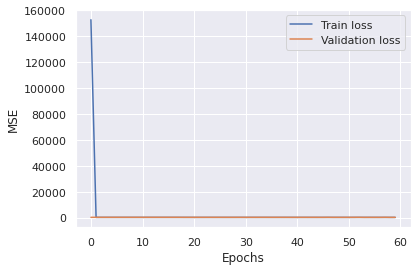

In [22]:
# plots 
fig = plt.figure()
plt.plot(mlp_history.history['loss'], label='Train loss')
plt.plot(mlp_history.history['val_loss'], label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('MSE')

In [23]:
# RMSE calculation
from sklearn.metrics import mean_squared_error
mlp_train_pred = model_mlp.predict(X_train_flattened)
mlp_test_pred = model_mlp.predict(X_test_flattened)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, mlp_train_pred)))
print('Test rmse:', np.sqrt(mean_squared_error(y_test, mlp_test_pred)))

Train rmse: 8.740465730788044
Test rmse: 10.801179881066563


In [24]:
print(y_test[0:10])
print(mlp_test_pred[0:10])

[2515.   2516.   2513.6  2513.25 2517.55 2514.25 2515.   2511.35 2510.4
 2506.  ]
[[2502.5693]
 [2506.6687]
 [2509.0234]
 [2509.5173]
 [2510.6628]
 [2512.0156]
 [2512.6272]
 [2512.6443]
 [2512.3086]
 [2511.5205]]


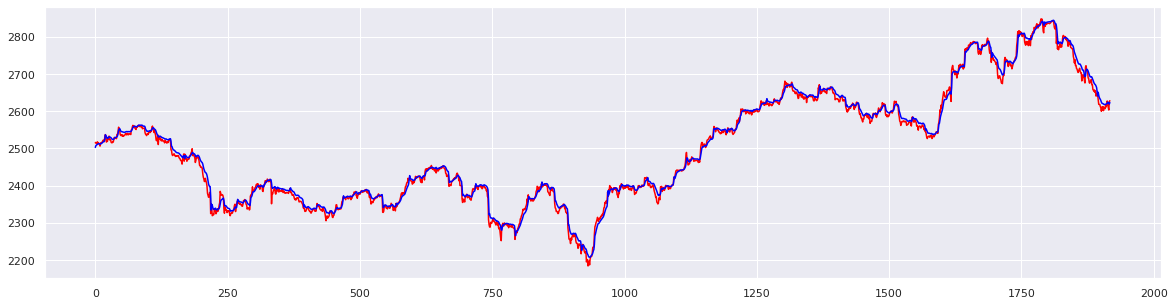

In [25]:
# pd.Series(y_test[:100]).plot(figsize=(30, 10))
# pd.Series(cnn_test_pred.flatten()[:100]).plot(figure=(30, 10))
plt.figure(figsize=(20, 5))
plt.plot(pd.Series(y_test), color='red')
plt.plot(pd.Series(mlp_test_pred.flatten()), color='blue')

In [26]:
# MAPE calculation
from sklearn.metrics import mean_absolute_percentage_error
print('Train MAPE:', mean_absolute_percentage_error(y_train, mlp_train_pred))
print('Test MAPE:', mean_absolute_percentage_error(y_test, mlp_test_pred))

Train MAPE: 0.002897846015294833
Test MAPE: 0.0032754907373283106
